# Using traditional models and feature engineering to classify SHL timeseries

In [1]:
from pathlib import Path

# We are going to train the models on a small subsample of the whole dataset
# The assumption behind this is that traditional models require significantly
# less amount of training data

DATASET_DIRS = [
    Path('shl-dataset/challenge-2019-train_torso.zip'),
    Path('shl-dataset/challenge-2019-train_bag.zip'),
    Path('shl-dataset/challenge-2019-train_hips.zip'),
    Path('shl-dataset/challenge-2020-train_hand.zip'),
]

NROWS_PER_DATASET = 5000

In [2]:
# Create scalers that we will fit on our data

from sklearn.preprocessing import PowerTransformer

acc_scaler = PowerTransformer()
mag_scaler = PowerTransformer()
gyr_scaler = PowerTransformer()

In [3]:
import numpy as np

from tools.dataset import load_zipped_shl_dataset

from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

# Join all datasets
acc_mag_conc = None
mag_mag_conc = None
gyr_mag_conc = None
y_conc = None

for dataset_dir in DATASET_DIRS:
    # Load dataset from zip file into temporary directory
    dataset = load_zipped_shl_dataset(dataset_dir, tqdm=tqdm, nrows=NROWS_PER_DATASET)
    if acc_mag_conc is None:
        acc_mag_conc = dataset.acc_mag
    else:
        acc_mag_conc = np.concatenate((acc_mag_conc, dataset.acc_mag), axis=0)
    if mag_mag_conc is None:
        mag_mag_conc = dataset.mag_mag
    else:
        mag_mag_conc = np.concatenate((mag_mag_conc, dataset.mag_mag), axis=0)
    if gyr_mag_conc is None:
        gyr_mag_conc = dataset.gyr_mag
    else:    
        gyr_mag_conc = np.concatenate((gyr_mag_conc, dataset.gyr_mag), axis=0)
    if y_conc is None:
        y_conc = dataset.labels
    else:
        y_conc = np.concatenate((y_conc, dataset.labels), axis=0)
    del dataset

Extracting shl-dataset\challenge-2019-train_torso.zip: 100%|██████████| 22/22 [03:10<00:00,  8.67s/it]


Acc_x Import Done
Acc_y Import Done
Acc_z Import Done
Acc_mag Import Done
Mag_x Import Done
Mag_y Import Done
Mag_z Import Done
Mag_mag Import Done
Gyr_x Import Done
Gyr_y Import Done
Gyr_z Import Done
Gyr_mag Import Done
Labels Import Done


Extracting shl-dataset\challenge-2019-train_bag.zip: 100%|██████████| 22/22 [03:28<00:00,  9.49s/it]


Acc_x Import Done
Acc_y Import Done
Acc_z Import Done
Acc_mag Import Done
Mag_x Import Done
Mag_y Import Done
Mag_z Import Done
Mag_mag Import Done
Gyr_x Import Done
Gyr_y Import Done
Gyr_z Import Done
Gyr_mag Import Done
Labels Import Done


Extracting shl-dataset\challenge-2019-train_hips.zip: 100%|██████████| 22/22 [03:27<00:00,  9.43s/it]


Acc_x Import Done
Acc_y Import Done
Acc_z Import Done
Acc_mag Import Done
Mag_x Import Done
Mag_y Import Done
Mag_z Import Done
Mag_mag Import Done
Gyr_x Import Done
Gyr_y Import Done
Gyr_z Import Done
Gyr_mag Import Done
Labels Import Done


Extracting shl-dataset\challenge-2020-train_hand.zip: 100%|██████████| 23/23 [03:30<00:00,  9.15s/it]


Acc_x Import Done
Acc_y Import Done
Acc_z Import Done
Acc_mag Import Done
Mag_x Import Done
Mag_y Import Done
Mag_z Import Done
Mag_mag Import Done
Gyr_x Import Done
Gyr_y Import Done
Gyr_z Import Done
Gyr_mag Import Done
Labels Import Done


In [4]:
# Check that we don't have NaNs in our dataset
assert not np.isnan(acc_mag_conc).any()
assert not np.isnan(mag_mag_conc).any()
assert not np.isnan(gyr_mag_conc).any()

# Fit and export scalers
acc_mag_scaled = acc_scaler.fit_transform(acc_mag_conc)
del acc_mag_conc
mag_mag_scaled = mag_scaler.fit_transform(mag_mag_conc)
del mag_mag_conc
gyr_mag_scaled = gyr_scaler.fit_transform(gyr_mag_conc)
del gyr_mag_conc

In [5]:
import numpy as np

from scipy import signal
from scipy.special import entr


def magnitude(x,y,z):
  return np.sqrt(x**2 + y**2 + z**2)

def entrop(pk,axis=0):
     pk = pk / np.sum(pk, axis=axis, keepdims=True)
     vec = entr(pk)
     S = np.sum(vec, axis=axis)
     return S

def autocorr(x,axis=0):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

# Statistical Feature Calculation
acc_mean = np.mean(acc_mag_scaled,axis=1)
acc_std = np.std(acc_mag_scaled,axis=1)
acc_max = np.max(acc_mag_scaled,axis=1)
acc_min = np.min(acc_mag_scaled,axis=1)

mag_mean = np.mean(mag_mag_scaled,axis=1)
mag_std = np.std(mag_mag_scaled,axis=1)
mag_max = np.max(mag_mag_scaled,axis=1)
mag_min = np.min(mag_mag_scaled,axis=1)

gyr_mean = np.mean(gyr_mag_scaled,axis=1)
gyr_std = np.std(gyr_mag_scaled,axis=1)
gyr_max = np.max(gyr_mag_scaled,axis=1)
gyr_min = np.min(gyr_mag_scaled,axis=1)

# Frequency Domain Feature Calculation
fs = 100
acc_FREQ,acc_PSD = signal.welch(acc_mag_scaled,fs,nperseg=500,axis=1)
mag_FREQ,mag_PSD = signal.welch(mag_mag_scaled,fs,nperseg=500,axis=1)
gyr_FREQ,gyr_PSD = signal.welch(gyr_mag_scaled,fs,nperseg=500,axis=1)

# Max PSD value
acc_PSDmax = np.max(acc_PSD,axis=1)
mag_PSDmax = np.max(mag_PSD,axis=1)
gyr_PSDmax = np.max(gyr_PSD,axis=1)
acc_PSDmin = np.min(acc_PSD,axis=1)
mag_PSDmin = np.min(mag_PSD,axis=1)
gyr_PSDmin = np.min(gyr_PSD,axis=1)

# Frequency Entropy
acc_entropy = entrop(acc_PSD,axis=1)
mag_entropy = entrop(mag_PSD,axis=1)
gyr_entropy = entrop(gyr_PSD,axis=1)

# Frequency Center
acc_fc = np.sum((acc_FREQ*acc_PSD),axis=1) / np.sum(acc_PSD,axis=1)
mag_fc = np.sum((mag_FREQ*mag_PSD),axis=1) / np.sum(mag_PSD,axis=1)
gyr_fc = np.sum((gyr_FREQ*gyr_PSD),axis=1) / np.sum(gyr_PSD,axis=1)

# Autocorrelation Calculation
acc_acr = np.apply_along_axis(autocorr,1,acc_mag_scaled)
mag_acr = np.apply_along_axis(autocorr,1,mag_mag_scaled)
gyr_acr = np.apply_along_axis(autocorr,1,gyr_mag_scaled)

acc_features = np.stack((acc_mean,acc_std,acc_max,acc_min,acc_PSDmax,acc_PSDmin,acc_entropy,acc_fc),axis=1)
mag_features = np.stack((mag_mean,mag_std,mag_max,mag_min,mag_PSDmax,mag_PSDmin,mag_entropy,mag_fc),axis=1)
gyr_features = np.stack((gyr_mean,gyr_std,gyr_max,gyr_min,gyr_PSDmax,gyr_PSDmin,gyr_entropy,gyr_fc),axis=1)

X = np.concatenate([acc_features,mag_features,gyr_features],axis=1)

print("X shape: ",X.shape)
print("y shape: ",y_conc.shape)

print("Feature Extraction Done")

X shape:  (20000, 24)
y shape:  (20000,)
Feature Extraction Done


In [6]:
# Install imblearn, a package with functionalities to balance our dataset
import sys
!{sys.executable} -m pip install imbalanced-learn

You are using pip version 18.1, however version 21.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_conc, test_size=0.33, random_state=1337)

In [8]:
# Weight train dataset classes using SMOTE
from imblearn.over_sampling import SMOTE

oversampler = SMOTE()
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [9]:
# Check that classes are now balanced
print(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train))

[1. 1. 1. 1. 1.]


In [17]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

names = [
    "KNN", "SVM",
    "DT", "RF", "MLP",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
]

In [18]:
import tempfile
import os

from joblib import dump

accuracies = []
f1scores = []
model_sizes = []

for model_name, model in zip(names, classifiers):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f'Acc of {model_name}: {accuracy}')
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1scores.append(f1)
    print(f'F1 of {model_name}: {f1}')

    with tempfile.TemporaryDirectory() as tmp_dir:
        filename = f"{tmp_dir}/model.joblib"
        dump(model, filename)
        model_size = os.path.getsize(filename)
        model_sizes.append(model_size)
        print(f'Size of {model_name} in Bytes: {model_size}')


Acc of KNN: 0.6665151515151515
F1 of KNN: 0.6683342010733391
Size of KNN in Bytes: 6710000
Acc of SVM: 0.6357575757575757
F1 of SVM: 0.6422544914428083
Size of SVM in Bytes: 4666066
Acc of DT: 0.6239393939393939
F1 of DT: 0.6115928220416167
Size of DT in Bytes: 7020
Acc of RF: 0.6310606060606061
F1 of RF: 0.6348319867600494
Size of RF in Bytes: 58734
Acc of MLP: 0.7031818181818181
F1 of MLP: 0.7041660371422821
Size of MLP in Bytes: 105138


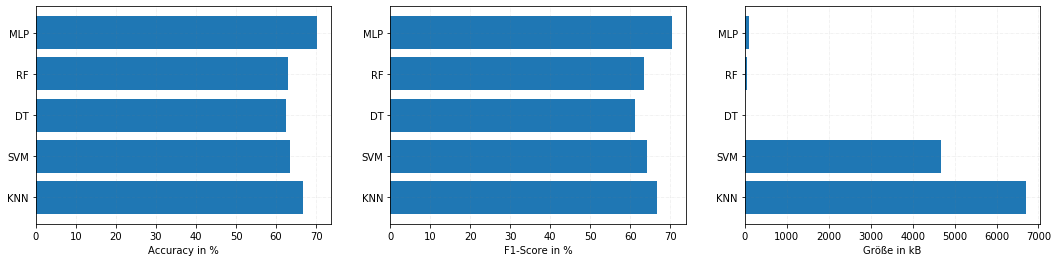

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(6 * 3, 4)

axs[0].barh(names, [a * 100 for a in accuracies], color='grey')
axs[0].set_xlabel('Accuracy in %')

axs[1].barh(names, [f1 * 100 for f1 in f1scores], color='grey')
axs[1].set_xlabel('F1-Score in %')

axs[2].barh(names, [s / 1_000 for s in model_sizes], color='grey')
axs[2].set_xlabel('Größe in kB')

for i in range(3):
    axs[i].grid(
        b = True, 
        color ='grey',
        linestyle ='-.', 
        linewidth = 0.5,
        alpha = 0.2
    )

plt.show()